In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.16.2
1 Physical GPUs, 1 Logical GPUs


In [3]:
# clean for debug purpose only 

trainData = None
valData = None
testData = None
model = None

tf.keras.backend.clear_session(free_memory=True)


## Loading the data

Since there were multiple labels, I decided to write a custom import for the images and labels.

I calculated the weights for each label, so that I can use them later on for a custom loss function and metric.

In [36]:
# load images and labels 
from collections import Counter
import csv

imageFileNames = tf.data.Dataset.list_files('./images/*', shuffle=False)

allLabelDict = {}

numTrainImages = 0
labelDict = Counter()
cellShapeDict = Counter()
nucleusShapeDict = Counter()
cytoplasmVacuoleDict = Counter()

# loads the labels from the csv 
with open("./dev_data_2025.csv", "r") as f:
	csvItems = list(csv.DictReader(f))
	for imgLabel in csvItems:
		numTrainImages += 1
		labelDict[imgLabel['label']] += 1
		cellShapeDict[imgLabel['cell_shape']] += 1
		nucleusShapeDict[imgLabel['nucleus_shape']] += 1
		cytoplasmVacuoleDict[imgLabel['cytoplasm_vacuole']] += 1

	labelTuple = tuple(labelDict.keys())
	cellShapeTuple = tuple(cellShapeDict.keys())
	nucleusShapeTuple = tuple(nucleusShapeDict.keys())
	cytoplasmVacuoleTuple = tuple(cytoplasmVacuoleDict.keys())
	
	for imgLabel in csvItems:
		allLabelDict[imgLabel['imageID']] = [
			labelTuple.index(imgLabel['label']), 
			cellShapeTuple.index(imgLabel['cell_shape']), 
			nucleusShapeTuple.index(imgLabel['nucleus_shape']), 
			cytoplasmVacuoleTuple.index(imgLabel['cytoplasm_vacuole'])
		]

# A weighting for the classes to help prevent over fitting to over represented classes 
classWeightsRaw = {
	'label': {key: (labelDict[key] / numTrainImages) for key in labelTuple},
	'cellShape': {key: (cellShapeDict[key] / numTrainImages) for key in cellShapeTuple},
	'nucleusShape': {key: (nucleusShapeDict[key] / numTrainImages) for key in nucleusShapeTuple},
	'cytoplasmVacuole': {key: (cytoplasmVacuoleDict[key] / numTrainImages) for key in cytoplasmVacuoleTuple}
}

classWeights = {key: np.array([(weight**-1)*2 for weight in weights.values()]) for key, weights in classWeightsRaw.items()} 

# Estimate the accuracy of a model maKing random guesses  
classRandomAcc = {
	'label': sum([(i / numTrainImages)**2 for i in labelDict.values()]),
	'cellShape': sum([(i / numTrainImages)**2 for i in cellShapeDict.values()]),
	'nucleusShape': sum([(i / numTrainImages)**2 for i in nucleusShapeDict.values()]),
	'cytoplasmVacuole': sum([(i / numTrainImages)**2 for i in cytoplasmVacuoleDict.values()])
}

print(f'label class imbalance in %: {classWeightsRaw["label"]} | target % {1 / len(labelDict)}')
print(f'label class weights: {classWeights["label"]} | random guess accuracy {classRandomAcc["label"]}')
print(f'cell shape class imbalance in %: {classWeightsRaw["cellShape"]} | target % {100 / len(cellShapeDict)}')
print(f'cell shape class weights: {classWeights["cellShape"]} | random guess accuracy {classRandomAcc["cellShape"]}')
print(f'nucleus shape class imbalance in %: {classWeightsRaw["nucleusShape"]} | target % {100 / len(nucleusShapeDict)}')
print(f'nucleus shape class weights: {classWeights["nucleusShape"]} | random guess accuracy {classRandomAcc["nucleusShape"]}')
print(f'cytoplasm vacuole class imbalance in %: {classWeightsRaw["cytoplasmVacuole"]} | target % {100 / len(cytoplasmVacuoleDict)}')
print(f'cytoplasm vacuole class weights: {classWeights["cytoplasmVacuole"]} | random guess accuracy {classRandomAcc["cytoplasmVacuole"]}')


label class imbalance in %: {'Lymphocyte': 0.1158, 'Monocyte': 0.1358, 'Basophil': 0.1256, 'Neutrophil': 0.322, 'Eosinophil': 0.3008} | target % 0.2
label class weights: [17.27115717 14.7275405  15.92356688  6.21118012  6.64893617] | random guess accuracy 0.24179128
cell shape class imbalance in %: {'round': 0.7808, 'irregular': 0.2192} | target % 50.0
cell shape class weights: [2.56147541 9.12408759] | random guess accuracy 0.65769728
nucleus shape class imbalance in %: {'unsegmented-round': 0.1032, 'unsegmented-indented': 0.1298, 'irregular': 0.0858, 'segmented-multilobed': 0.1252, 'unsegmented-band': 0.258, 'segmented-bilobed': 0.298} | target % 16.666666666666668
nucleus shape class weights: [19.37984496 15.40832049 23.31002331 15.97444089  7.75193798  6.7114094 ] | random guess accuracy 0.20590296
cytoplasm vacuole class imbalance in %: {'no': 0.9278, 'yes': 0.0722} | target % 50.0
cytoplasm vacuole class weights: [ 2.15563699 27.70083102] | random guess accuracy 0.866025679999999

## Creating the tensorflow dataset

Now that I had the data I needed to create the tensorflow dataset that supports multiple labels because the model will need to classify multiple classes.

I used the map function on the image files already imported to load the Images into [360, 360, 3] tensors and then I added the labels generated above. 

The labels needed to be in the form of a dict for the loss function to read them correctly but `py_function` only returns tensors so I had to add an extra function to convert the labels again. 

To improve the training I added some basic data augmentation that randomizes the orientation of the images used for training. 
I chose to only change the orientation because other factors liKe brightness and contrast was fairly consistent across the whole dataset due to the fact that the cell imaging machine produced fairly uniform brightness images.      

I used a 70/30 split for training and validation data and the rest was already designated as test.

In [37]:
valSize = int(numTrainImages * 0.3)
batchSize = 100

In [ ]:
def getLabel(path):
	path = path.numpy().decode("utf-8")
	Key = os.path.basename(path)[:9]
	
	if Key not in allLabelDict:
		print("Missing Key:", Key)
		raise ValueError("Missing label Key.")
	return tf.convert_to_tensor(allLabelDict[Key])

def getImage(path):
	img = tf.io.read_file(path)
	return tf.io.decode_and_crop_jpeg(img, crop_window=[0,0,360,360], channels=3)
	

def processData(file_path):
	label = tf.py_function(func=getLabel, inp=[file_path], Tout=tf.int32)
	label.set_shape([4])

	img = tf.py_function(func=getImage, inp=[file_path], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label

def labelsToDict(img, label):
	label.set_shape([4])

	labelDict = {
		"labelOutput": tf.convert_to_tensor([label[0]]),
    "cellShapeOutput": tf.convert_to_tensor([label[1]]),
    "nucleusShapeOutput": tf.convert_to_tensor([label[2]]),
    "cytoplasmVacuoleOutput": tf.convert_to_tensor([label[3]])
	}

	img.set_shape([360, 360, 3])
	return img, labelDict

def augmentFn(img):
	img = tf.image.random_flip_left_right(img)
	img = tf.image.random_flip_left_right(img)
	return img

def augment(img, label):
	img = tf.py_function(func=augmentFn, inp=[img], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label


trainData = imageFileNames \
  .skip(valSize) \
	.take(numTrainImages - valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(augment, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 
	
valData = imageFileNames \
  .take(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 

testData = imageFileNames \
	.skip(numTrainImages) \
	.map(getImage, num_parallel_calls=tf.data.AUTOTUNE) \
	.batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 

print(f"train data size {tf.data.experimental.cardinality(trainData).numpy() * batchSize}")
print(f"val data size {tf.data.experimental.cardinality(valData).numpy() * batchSize}")
print(f"test data size {tf.data.experimental.cardinality(testData).numpy() * batchSize}")


train data size 3500
val data size 1500
test data size 5300


# Training

The performance metric I chose to optimize for needed to handle heavily imbalanced data so I chose to take the accuracy of my model at predicting each class then taking the weighted arithmetic mean of all of those. I could have also used the macro or micro F1 score but I chose to use accuracy because it is a simple metric that has more real world meaning than the F1 score. For medical this algorithm to be useful in medical diagnosis I want to target an average accuracy of 97.5%, while this is a fairly low accuracy target since the goal of this project is to classify a large number of cells I figure that the count and ratio of call types is the more important than getting every single cell correctly labeled. 

Below is the code I used to compile, train, and evaluate all the models.
I created my own custom loss function based off sparse categorical cross entropy but I added weights to compensate for the class imbalance.
I created accuracy metrics for each class. 

In [40]:
# Compiling

def customAccuracyGenerator(classIndex: int):
	@tf.keras.utils.register_keras_serializable()
	def classAccuracy(y_true, y_pred):
		y_true = tf.reshape(y_true, [-1])
		y_true = tf.cast(y_true, tf.int8)

		y_pred = tf.argmax(y_pred, 1)
		y_pred = tf.cast(y_pred, tf.int8)

		classMask = tf.constant([classIndex for i in range(batchSize)], dtype=tf.int8)
		
		maskComparison = tf.math.equal(y_true, classMask)
		comparison = tf.math.logical_and(tf.math.equal(y_true, y_pred), maskComparison)
		
		return tf.math.divide_no_nan(tf.math.count_nonzero(comparison), tf.math.count_nonzero(maskComparison))
	
	return classAccuracy

def customLossGenerator(weights):
	lossFn = tf.keras.losses.SparseCategoricalCrossentropy()
	@tf.keras.utils.register_keras_serializable()
	def customLoss(y_true, y_pred):
		return weights[tf.get_static_value(y_true)] * lossFn(y_true, y_pred)
	
	return customLoss

model.compile(
  optimizer='adam',
  loss={
		'labelOutput': customLossGenerator(classWeights['label']),
		'cellShapeOutput': customLossGenerator(classWeights['cellShape']),
		'nucleusShapeOutput': customLossGenerator(classWeights['nucleusShape']),
		'cytoplasmVacuoleOutput': customLossGenerator(classWeights['cytoplasmVacuole'])
	},
  metrics={
		'labelOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(labelTuple))],
		'cellShapeOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(cellShapeTuple))],
		'nucleusShapeOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(nucleusShapeTuple))],
		'cytoplasmVacuoleOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(cytoplasmVacuoleTuple))]
	},
)

In [41]:
# Training

history = model.fit(
  trainData,
  validation_data=valData,
  epochs=32,
  batch_size=batchSize
)

Epoch 1/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - cellShapeOutput_accuracy: 0.7494 - cellShapeOutput_class_accuracy: 0.8636 - cellShapeOutput_class_accuracy_1: 0.3616 - cellShapeOutput_loss: 6.2535 - cytoplasmVacuoleOutput_accuracy: 0.9217 - cytoplasmVacuoleOutput_class_accuracy: 0.9627 - cytoplasmVacuoleOutput_class_accuracy_1: 0.3588 - cytoplasmVacuoleOutput_loss: 5.4627 - labelOutput_accuracy: 0.5171 - labelOutput_class_accuracy: 0.5439 - labelOutput_class_accuracy_1: 0.4157 - labelOutput_class_accuracy_2: 0.3716 - labelOutput_class_accuracy_3: 0.6046 - labelOutput_class_accuracy_4: 0.5225 - labelOutput_loss: 32.6565 - loss: 90.7921 - nucleusShapeOutput_accuracy: 0.3563 - nucleusShapeOutput_class_accuracy: 0.2948 - nucleusShapeOutput_class_accuracy_1: 0.3495 - nucleusShapeOutput_class_accuracy_2: 0.2366 - nucleusShapeOutput_class_accuracy_3: 0.0951 - nucleusShapeOutput_class_accuracy_4: 0.4519 - nucleusShapeOutput_class_accuracy_5: 0.4306 - nucleusShapeOutput_loss: 41.8717 - va

In [43]:
model.save('./final.keras')

# The model

I chose to use a the convocational layers from the pre-trained MobileNetV3Large model as a base because of its small size and its strong performance on imagenet dataset. I then added a series of 6 shared dense layers with 2 dropout layers and realization on 4 of the dense layers to help with overfitting that became an issue during training. The first third and sixth layers were then concatenated together to form the final shared layer, I added these skip connections to improve training performance. I then gave each output and extra 64 wide dense layer and the cell shape and nucleus shape dense layer got regularization because those outputs showed signs of overfitting more than the rest of the model outputs.  

In [39]:
# input and rescale
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))

# imagenet pre made model
baseModel = tf.keras.applications.MobileNetV3Large(
	weights='imagenet',  
	input_shape=(360, 360, 3),
	include_top=False,
	pooling='max'
)

baseModel.trainable = False
convoLayers = baseModel(inputLayer, training=False)

# shared model layers
dense1 = tf.keras.layers.Dense(256, activation='relu')(convoLayers)
dense2 = tf.keras.layers.Dense(256, activation='relu')(dense1)
dropout1 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3))(dropout1)
dense4 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3))(dense3)
dense5 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3))(dense4)
dropout2 = tf.keras.layers.Dropout(0.2)(dense5)
dense6 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3))(dropout2)
baseLayers = tf.keras.layers.Concatenate()([dense1, dense3, dense6])

#label 
labelLayers = baseLayers
labelLayers = tf.keras.layers.Dense(64, activation='relu')(labelLayers)
labelOutput = tf.keras.layers.Dense(len(labelTuple), activation='softmax', name='labelOutput')(labelLayers)

# cell shape
cellShapeLayers = baseLayers
cellShapeLayers = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3))(cellShapeLayers)
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple), activation='softmax', name='cellShapeOutput')(cellShapeLayers)

# nucleus shape
nucleusShapeLayers = baseLayers
nucleusShapeLayers = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2))(nucleusShapeLayers)
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple), activation='softmax', name='nucleusShapeOutput')(nucleusShapeLayers)

# cytoplasm vacuole
cytoplasmVacuoleLayers = baseLayers
cytoplasmVacuoleLayers = tf.keras.layers.Dense(64, activation='relu')(cytoplasmVacuoleLayers)
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple), activation='softmax', name='cytoplasmVacuoleOutput')(cytoplasmVacuoleLayers)

model = tf.keras.Model(
	name='multi-task-classifier',
	inputs=inputLayer, 
	outputs={
		'labelOutput': labelOutput,
		'cellShapeOutput': cellShapeOutput,
		'nucleusShapeOutput': nucleusShapeOutput,
		'cytoplasmVacuoleOutput': cytoplasmVacuoleOutput,
		}
)

model.summary()

/home/archfishgame/deep/deep-learning/.venv/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "multi-task-classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 960)       │  2,996,352 │ input_layer_12[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 256)       │    246,016 │ MobileNetV3Large… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 256)       │     65,792 │ dense_60[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 256)       │          0 │ dense_61[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 256)       │     65,792 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 128)       │     32,896 │ dense_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 128)       │     16,512 │ dense_63[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 128)       │          0 │ dense_64[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 128)       │     16,512 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 640)       │          0 │ dense_60[0][0],   │
│ (Concatenate)       │                   │            │ dense_62[0][0],   │
│                     │                   │            │ dense_65[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 64)        │     41,024 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 64)        │     41,024 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 64)        │     41,024 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 64)        │     41,024 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cellShapeOutput     │ (None, 2)         │        130 │ dense_67[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cytoplasmVacuoleOu… │ (None, 2)         │        130 │ dense_69[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labelOutput (Dense) │ (None, 5)         │        325 │ dense_66[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nucleusShapeOutput  │ (None, 6)         │        390 │ dense_68[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,604,943 (13.75 MB)

 Trainable params: 608,591 (2.32 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

### Results

The model has an accuracy of 91.5% on the training data and a validation accuracy of 73.8% and while this falls short of my target of 97.5% the label and cytoplasm vacuole prediction had accuracy in excess of 95% demonstrating that the model is useful in predicting some features. Looking at the nucleus shape results more closely it becomes apparent that there is a significant divergence between the training and validation datasets one that is not as prevalent in other outputs. Further for the nucleus shape there is also a large divergence in the accuracy of particular classes for example unsegmented predictions have a significantly higher accuracy than the segmented or irregular ones this likely owes to the small amount of segmented images compared to unsegmented ones.     

The model shows signs of overfitting and while adding more regularization did reduce the effects of this in my testing adding much more regularization reduced the training and validation accuracy significantly. 
Similarly increasing the size of the validation dataset had a large negative effect on the models performance. 

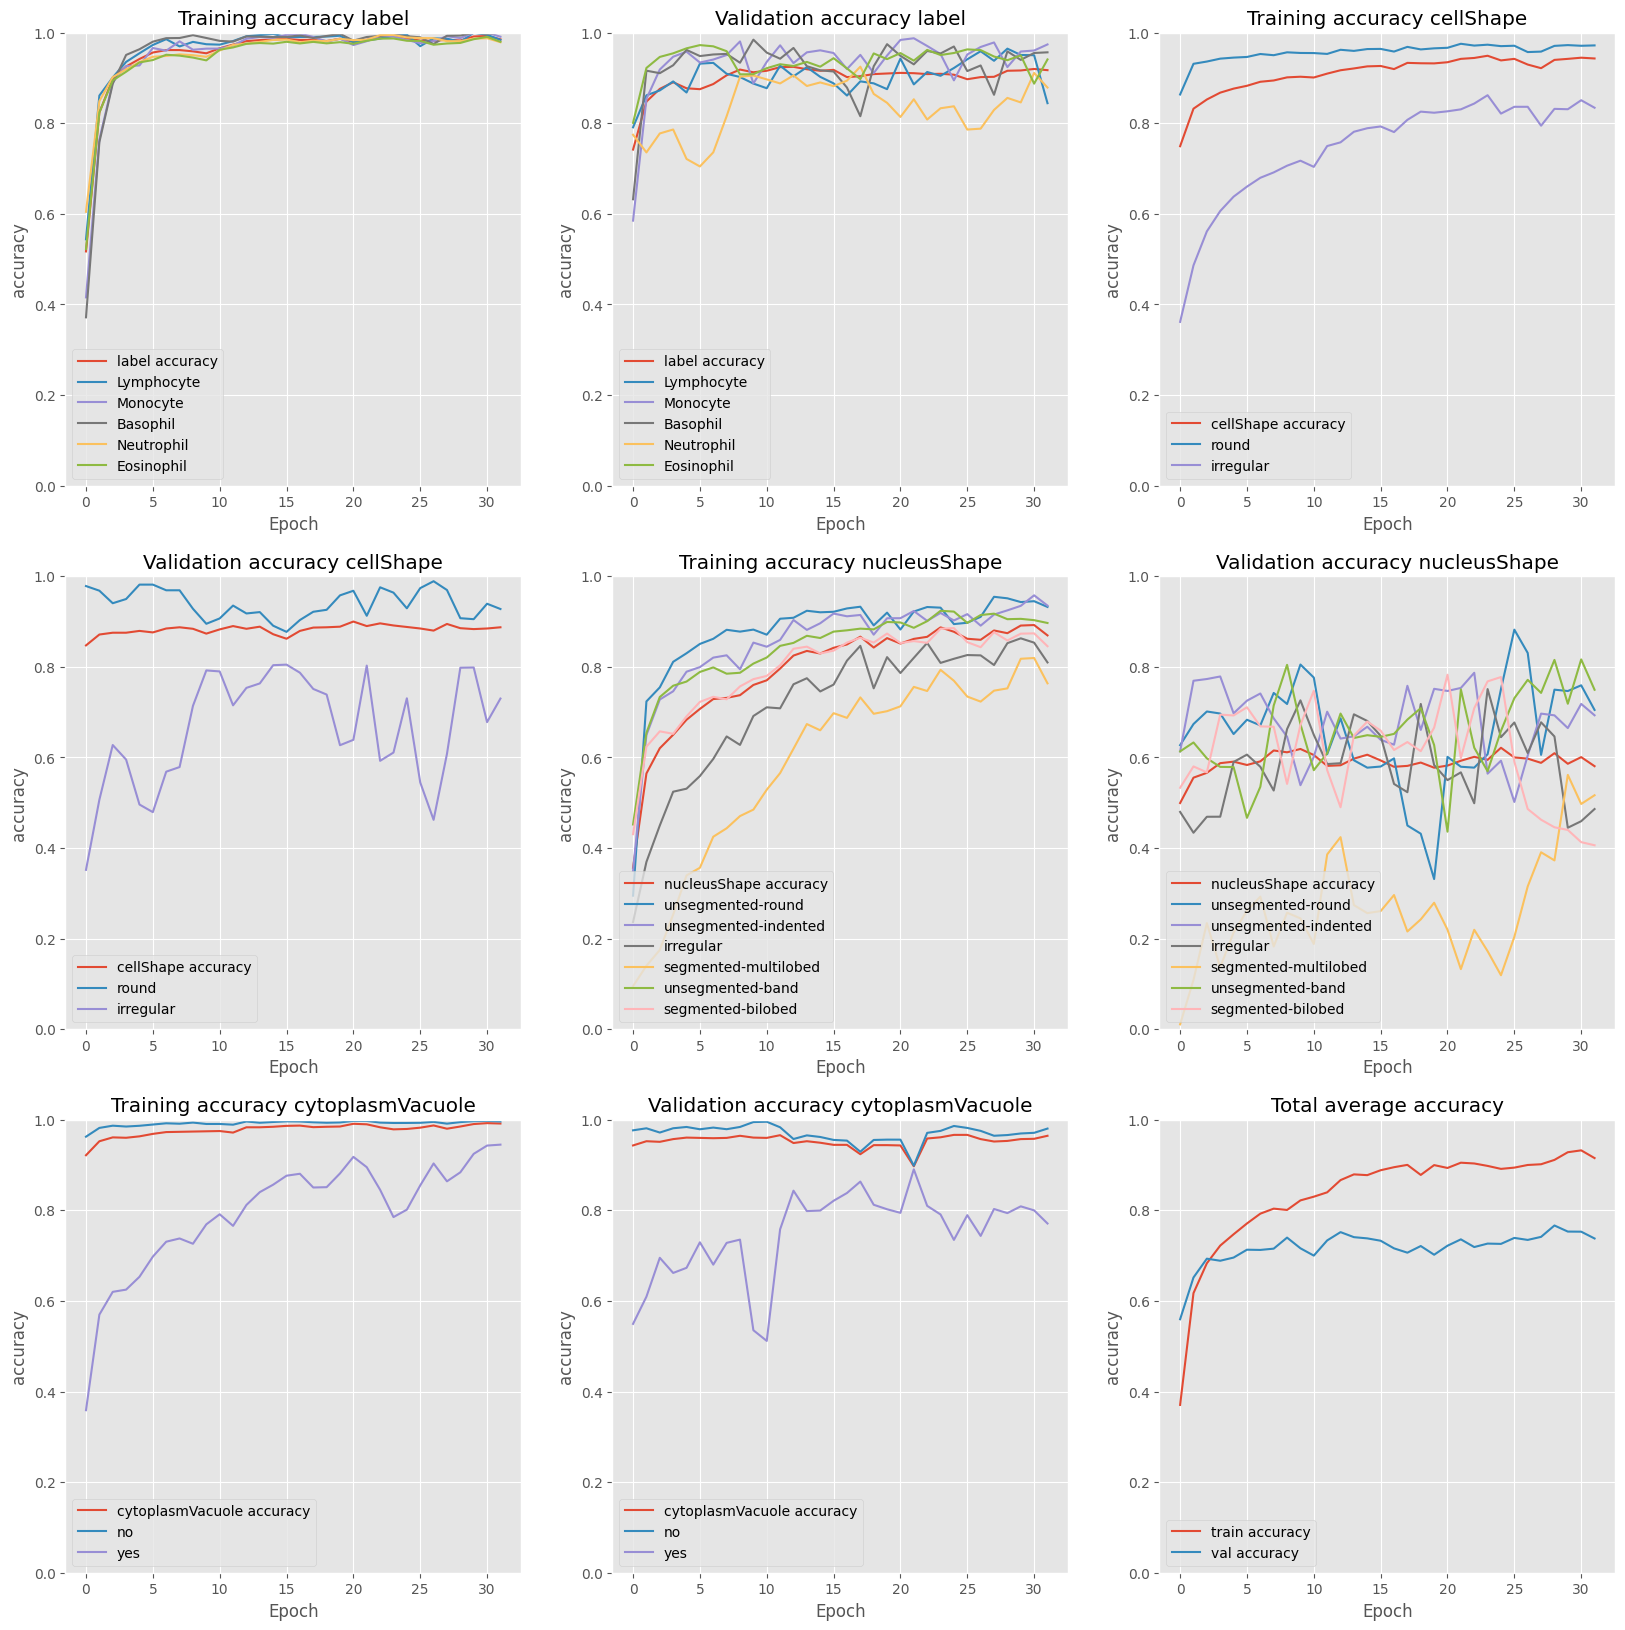

Average accuracy train: 0.9154469534419276
Average accuracy val: 0.7379455917784743


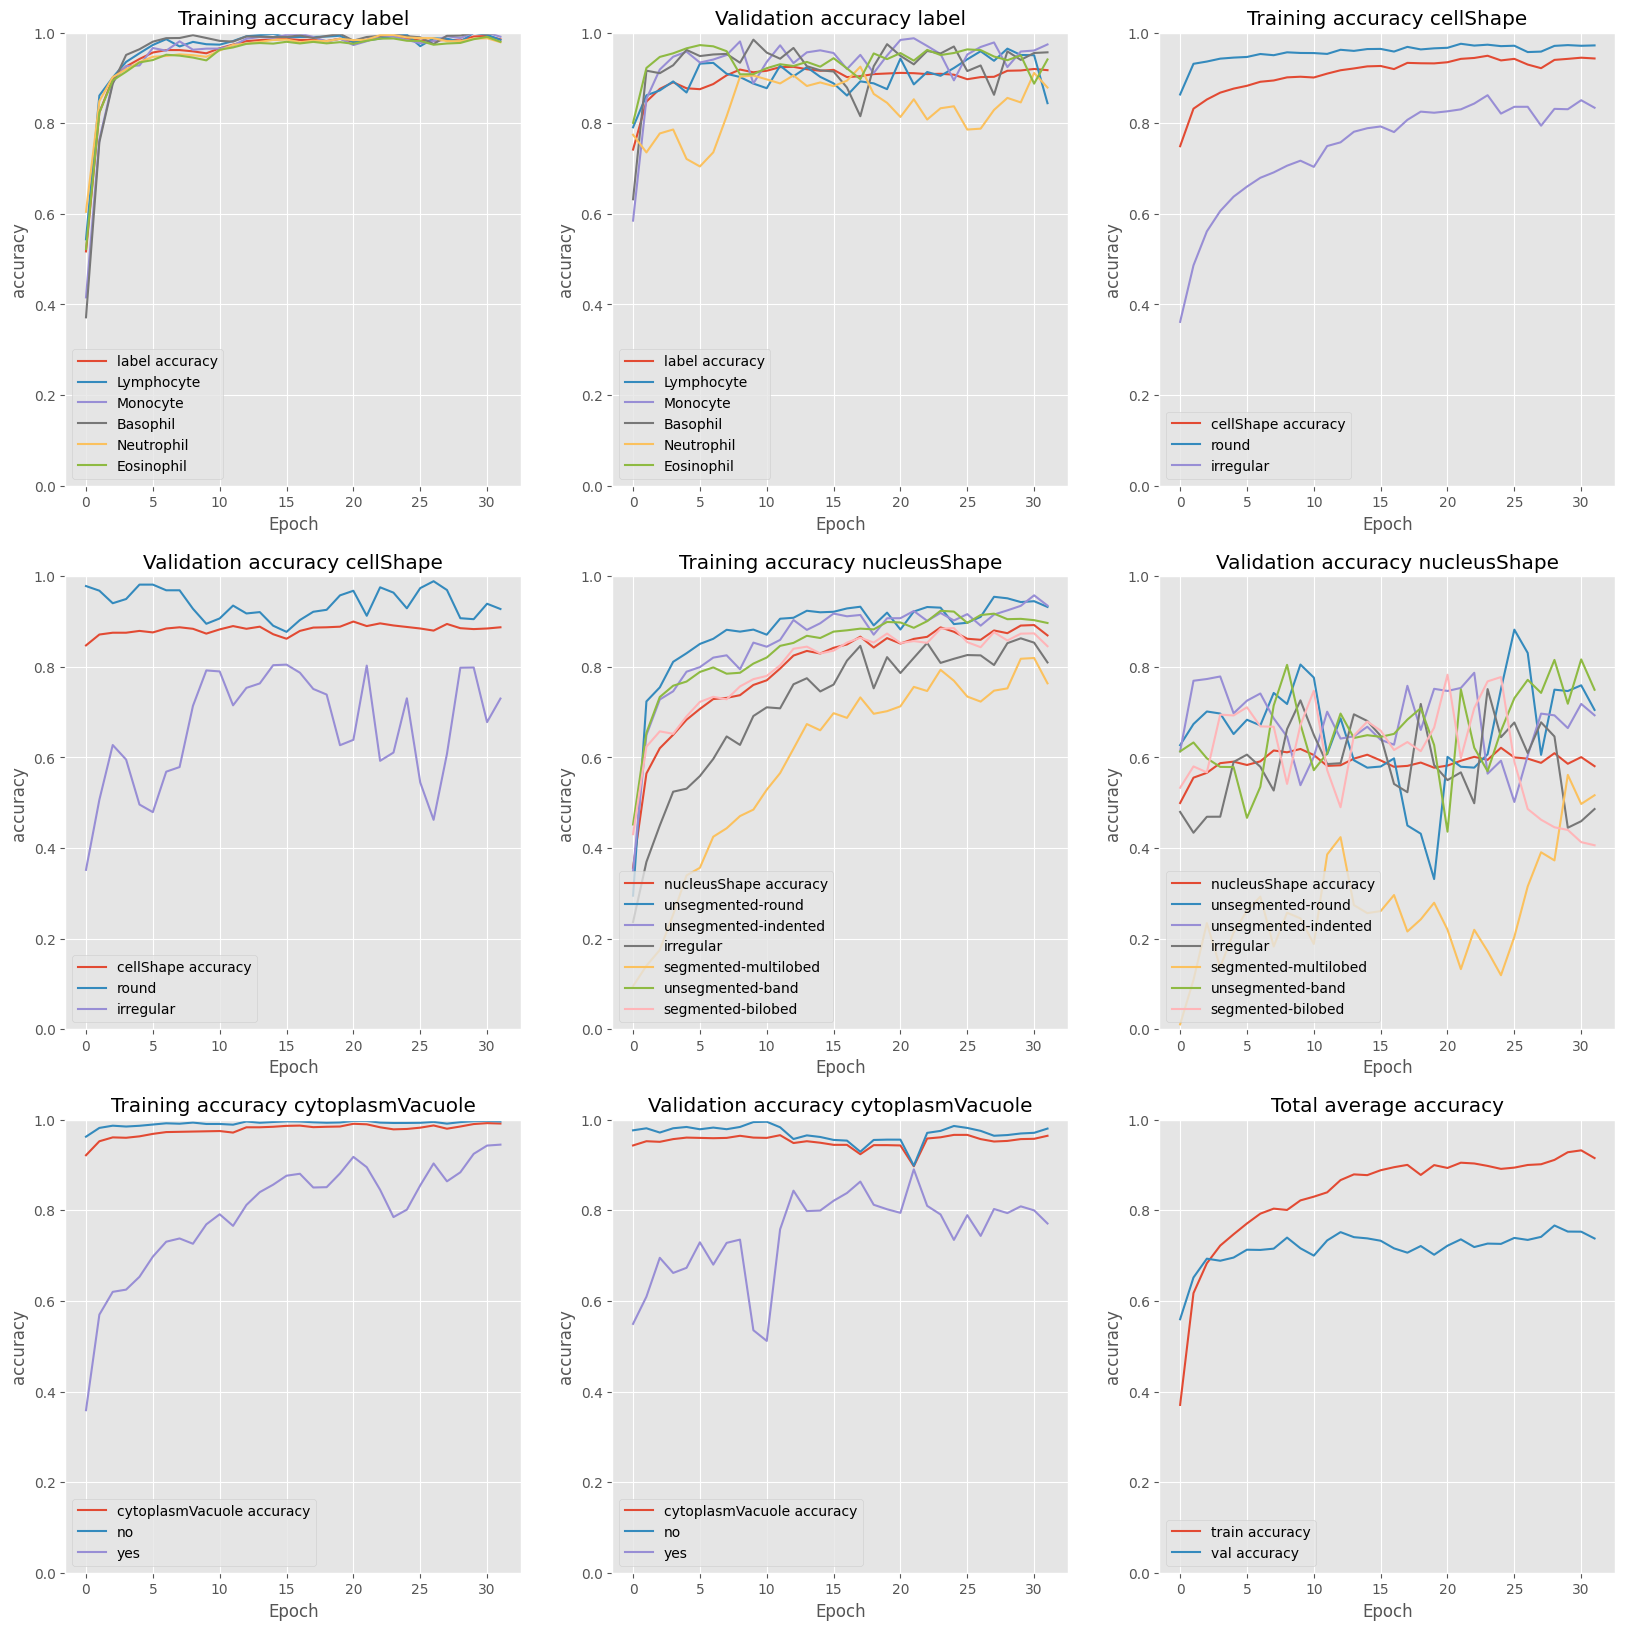

In [42]:
# Evaluation

plt.style.use("ggplot")
plt.figure(figsize=(20,20))
Nepoch=len(history.epoch)

targetMetricTrain = [0 for i in range(Nepoch)]
targetMetricVal = [0 for i in range(Nepoch)]
totalClasses = 0
totalWeights = 0

plotPos = 1
for outputType, outputClassWeights in classWeightsRaw.items(): 
	outputClassNames = list(outputClassWeights.keys())

	totalClasses += len(outputClassWeights)
	for i in range(len(outputClassWeights)):
		index = '' if i == 0 else f'_{i}'
		historyKey = f'{outputType}Output_class_accuracy{index}'
		
		inverseWeight = list(outputClassWeights.values())[i] ** -1
		totalWeights += inverseWeight

		for j in range(Nepoch):
			targetMetricTrain[j] += history.history[historyKey][j] *  inverseWeight
			targetMetricVal[j] += history.history[f'val_{historyKey}'][j] * inverseWeight

	plt.subplot(3,3,plotPos)
	plotPos += 1
	plt.plot(np.arange(0, Nepoch), history.history[f'{outputType}Output_accuracy'], label=f'{outputType} accuracy')

	for i in range(len(outputClassWeights)):
		index = '' if i == 0 else f'_{i}'
		key = f'{outputType}Output_class_accuracy{index}'
		
		plt.plot(np.arange(0, Nepoch), history.history[key], label=outputClassNames[i])

	plt.title(f"Training accuracy {outputType}")
	plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")

	plt.subplot(3,3,plotPos)
	plotPos += 1
	plt.plot(np.arange(0, Nepoch), history.history[f'val_{outputType}Output_accuracy'], label=f'{outputType} accuracy')

	for i in range(len(outputClassWeights)):
		index = '' if i == 0 else f'_{i}'
		key = f'val_{outputType}Output_class_accuracy{index}'
		
		plt.plot(np.arange(0, Nepoch), history.history[key], label=outputClassNames[i])

	plt.title(f"Validation accuracy {outputType}")
	plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")

targetMetricTrain = [i / totalWeights for i in targetMetricTrain]
targetMetricVal = [i / totalWeights for i in targetMetricVal]

plt.subplot(3,3,plotPos)
plt.plot(np.arange(0, Nepoch), targetMetricTrain, label='train accuracy')
plt.plot(np.arange(0, Nepoch), targetMetricVal, label='val accuracy')


plt.title("Total average accuracy")
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend(loc="lower left")

print(f'Average accuracy train: {targetMetricTrain[-1]}')
print(f'Average accuracy val: {targetMetricVal[-1]}')

plt.show()


# Final predictions

Code for generating final predictions

In [46]:
model = tf.keras.models.load_model('final.keras') 

predictions = model.predict(testData)

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step


In [53]:
import csv

numTestImages = len(imageFileNames) - numTrainImages
results = []

for i in range(numTestImages):
	results.append({
		'imageID': f"Img_{i + 1 + numTrainImages:05d}",
		'label': labelTuple[np.argmax(predictions['labelOutput'][i])], 
		'cell_shape': cellShapeTuple[np.argmax(predictions['cellShapeOutput'][i])],
		'nucleus_shape': nucleusShapeTuple[np.argmax(predictions['nucleusShapeOutput'][i])],
		'cytoplasm_vacuole': cytoplasmVacuoleTuple[np.argmax(predictions['cytoplasmVacuoleOutput'][i])]
	})

with open('s13947135_predictions.csv', 'w') as csvfile:
    fieldnames = ['imageID','label','cell_shape','nucleus_shape','cytoplasm_vacuole']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(results)